<style>div.container { width: 100% }</style>
<img style="float:left;  vertical-align:text-bottom;" height="65" width="172" src="../assets/holoviz-logo-unstacked.svg" />
<div style="float:right; vertical-align:text-bottom;"><h2>Tutorial 2: Building Panels</h2></div>

<a href="https://panel.pyviz.org"><img src="../assets/panel.png" width=150></a>

Panel is designed to make it simple to add interactive controls to your existing plots and data displays, simple to build apps for your own use in a notebook, simple to deploy apps as standalone dashboards to share with colleagues, and seamlessly shift back and forth between each of these tasks as your needs evolve. If there is one thing you should take away from this tutorial, it's Panel!

Throughout this tutorial we will use an earthquake dataset collected by the US Geological survey, so will start by loading it:

In [19]:
from load_data import *

df = load_data(constraints=constraints)
print(df.shape)
df.head()

(10087, 5)


,station,latitude,longitude,time,wvht
0,41048,31.978,-69.649,2021-01-09T16:40:00Z,5.83
1,41048,31.978,-69.649,2021-01-09T17:40:00Z,5.59
2,41048,31.978,-69.649,2021-01-09T18:40:00Z,5.46
3,41048,31.978,-69.649,2021-01-09T19:40:00Z,5.02
4,41048,31.978,-69.649,2021-01-09T20:40:00Z,5.03


Additionally before displaying anything with Panel it is always necessary to load the Panel extension:

In [2]:
import panel as pn

pn.extension()

## pn.interact

Before we get into the details of how Panel allows you to render and lay out objects we will dive straight in and use Panel's `interact` function, modeled on the similar function in `ipywidgets`, to get a simple interactive app immediately. For instance, if you have a function that returns a row of a dataframe given an index, you can very easily make a panel with a widget to control the row displayed.

In [3]:
def select_row(row=0):
    row = df.loc[row].to_frame()
    return row.style.format({"time": lambda t: t.strftime("%c")})

pn.interact(select_row, row=(0, len(df)-1))

Column
    [0] Column
        [0] IntSlider(end=287489, name='row')
    [1] Row
        [0] HTML(Styler, name='interactive00101')

This approach can be used for any function that returns a displayable object, calling the function whenever one of the parameters of that function has changed.  

In the spirit of "shortcuts, not dead ends", let's see what's in the object returned by `interact`:

In [4]:
app = pn.interact(select_row, row=(0, len(df)-1))

print(app)

Column
    [0] Column
        [0] IntSlider(end=287489, name='row')
    [1] Row
        [0] HTML(Styler, name='interactive00111')


Here, `interact` has constructed a Column panel consisting of one Column of widgets (with one widget), and one Row of output (with one HTML pane). This object, once created, is a full compositional Panel object, and can be reconfigured and expanded with additional content if you wish, without breaking the connections between widgets and values:

In [5]:
pn.Column("## Choose a row", pn.Row(app[0], app[1]))

Column
    [0] Markdown(str)
    [1] Row
        [0] Column
            [0] IntSlider(end=287489, name='row')
        [1] Row
            [0] HTML(Styler, name='interactive00111')

Hopefully from this simple example you can see the sorts of things Panel can do. In the rest of this section we'll cover some of the items you can use in a panel and how to compose them. In the subsequent section we will dive into how to set up widgets and their relationships explicitly, and then build a custom dashboard as an exercise.  For now, we won't show code for any particular plotting library, but if you have a favorite one already, you should be able to use it with Panel in the exercises.

## Component types

Before we start building more interactive apps, we will learn about the three main types of components in Panel:

* **Pane**: A Pane provides a view of an external object (text, image, plot, etc.) by wrapping it
* **Panel**: A Panel lays out multiple components in a row, column, or grid.
* **Widget**: A Widget provides input controls to add interactive features to your Panel.

If you ever want to discover how a particular component works, see the [reference gallery](https://panel.pyviz.org/reference/index.html).

## Displaying content

The fundamental concept behind Panel is that it transforms the objects you give it into a viewable object that can be composed into a layout and updated dynamically. In this tutorial we will be building a dashboard visualizing a dataset of earthquake events, so let us start by displaying a title using the `pn.panel` function:

In [6]:
title = pn.panel('## Wave Heights Dashboard')

title

Markdown(str)

In [7]:
df

,station,latitude,longitude,time,wvht
0,41002,31.887,-74.921,2021-07-01T00:50:00Z,0.8
1,41002,31.887,-74.921,2021-07-01T01:50:00Z,0.7
2,41002,31.887,-74.921,2021-07-01T02:50:00Z,0.8
3,41002,31.887,-74.921,2021-07-01T03:50:00Z,0.8
4,41002,31.887,-74.921,2021-07-01T04:50:00Z,0.8
...,...,...,...,...,...
287485,SSBN7,33.848,-78.482,2021-07-30T21:47:00Z,0.9
287486,SSBN7,33.848,-78.482,2021-07-30T22:17:00Z,1.0
287487,SSBN7,33.848,-78.482,2021-07-30T22:47:00Z,1.0
287488,SSBN7,33.848,-78.482,2021-07-30T23:17:00Z,1.0


To understand how Panel rendered this string we can take a look at the textual representation of this object:

In [8]:
# top 5 wave heights in July 2021
df_sorted = df.sort_values(by=['wvht'], ascending=False)
df_sorted.head()

,station,latitude,longitude,time,wvht
33719,42059,15.252,-67.483,2021-07-03T08:40:00Z,6.2
33720,42059,15.252,-67.483,2021-07-03T08:50:00Z,6.2
33718,42059,15.252,-67.483,2021-07-03T07:50:00Z,6.0
75423,44076,40.137,-70.775,2021-07-09T17:20:00Z,5.7
75424,44076,40.137,-70.775,2021-07-09T17:30:00Z,5.7


Panel transformed the `str` object and wrapped it in a so-called `Markdown` `Pane`. The ``pn.panel`` function attempts to find the most appropriate representation for different objects whether it is a string, an image, or even a plot. So if we provide the location of a PNG file instead as a path or a URL, the ``panel`` function will automatically infer that it should be rendered as an image:

PNG(str, height=130)
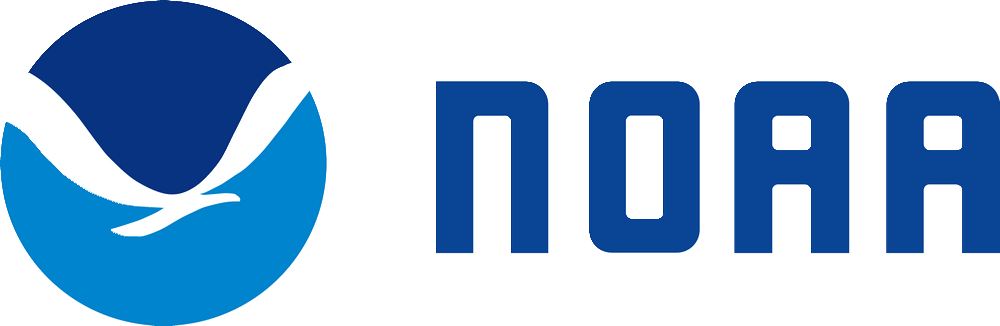

In [9]:
noaa_logo = pn.panel('../assets/noaa-lrg.png', height=130)
noaa_logo

The appropriate representation is resolved using a set of precedences, so it may sometimes be necessary to explicitly declare the type of Pane that is required. For example, if we want to display some `HTML`, which cannot easily be distinguished from Markdown, we can explicitly declare it by specifying the `HTML` Pane type from the `pn.pane` module:

In [10]:
pn.pane.HTML('<marquee width=500><b>Breaking news</b>: Major wave heights</marquee>')

HTML(str)

#### Exercise

Use the ``pn.panel`` function to display some different types of objects, e.g. an image, a pandas dataframe or even a plot you made.

Now construct the same type of object by explicitly constructing the appropriate type in the ``pn.pane`` module (Hint: Print the object in the previous example to find out what it is):

## Laying out content

In addition to `Pane` objects, Panel provides `Panel` objects that allow laying out components. The principal layouts are by ``Row`` or ``Column``. These components act just like a regular ``list`` in Python:

Column
    [0] Markdown(str)
    [1] PNG(str, height=130)
    [2] Column
        [0] Column
            [0] IntSlider(end=287489, name='row')
        [1] Row
            [0] HTML(Styler, name='interactive00111')
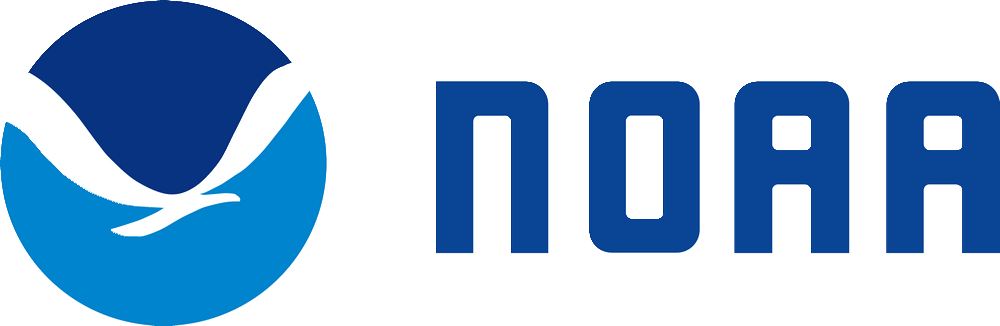

In [11]:
column = pn.Column(title, noaa_logo, app)

column

Panels may be nested arbitrarily to construct complex layouts. Internally, Panel will call the ``pn.panel`` function on any objects which are not already a known component type, making it easy to lay out objects without explicitly wrapping them in a panel component, though wrapping it explicitly can help ensure that it is the type you expect:

Row
    [0] Column
        [0] Markdown(str)
        [1] PNG(str, height=130)
        [2] Column
            [0] Column
                [0] IntSlider(end=287489, name='row')
            [1] Row
                [0] HTML(Styler, name='interactive00111')
    [1] Column
        [0] Markdown(str)
        [1] DataFrame(DataFrame, width=500)
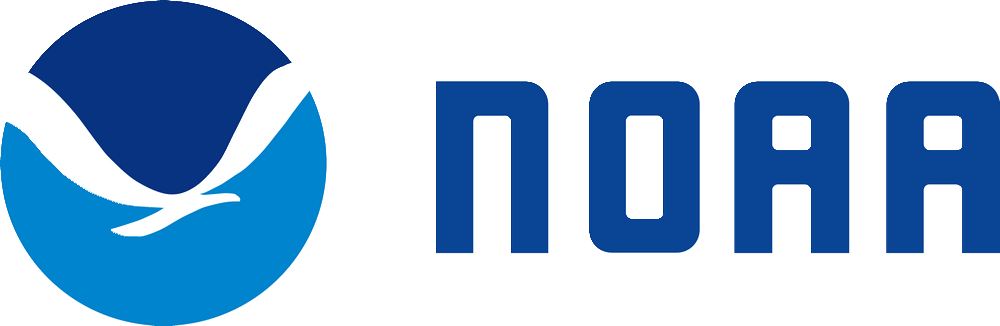

In [12]:
import pandas as pd

df_top5 = pd.DataFrame(df_sorted[0:10], columns=['station', 'time (UTC)', 'wvht'])

row = pn.Row(
    column,
    pn.Column(
        '### Top 5',
        pn.panel(df_top5, width=500)
    )
)

row

#### Exercise

Use ``Row`` and ``Column`` panels to lay out some of the objects (text, images, or plots) you rendered in the previous exercise.

Try swapping a ``Row`` or ``Column`` with a ``Tabs`` component:

## Updating content

So far we have only seen how Panel can be used to render and lay out objects, which on its own is not too exciting. However, all Panel objects can be modified once constructed, and all associated views will automatically update in response. Let us take the ``title`` pane we constructed above as an example:

This dynamic behavior also extends to Panels, whose Panes will update as they are changed:

Column
    [0] Markdown(str)
    [1] PNG(str, height=130)
    [2] Column
        [0] Column
            [0] IntSlider(end=287489, name='row')
        [1] Row
            [0] HTML(Styler, name='interactive00111')
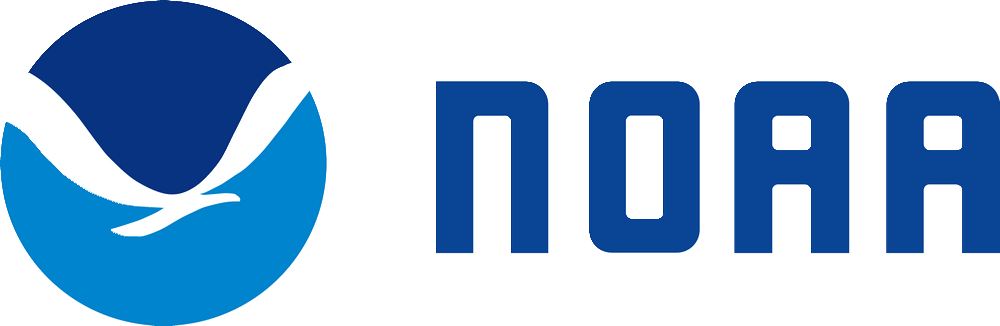

In [13]:
column

As we discussed above ``Row`` and ``Column`` Panels behave much like lists. Just like lists, we can use ``append``, ``pop``, ``remove``, ```insert```, and all the other standard methods (including setting with =) to modify them. E.g. we could dynamically insert a caption for the logo:

In [14]:
text = """
This dashboard displays the tallest waves
"""

In [15]:
column.insert(2, text)

If you uncomment and execute that cell, make sure to scroll back up to confirm that all versions of the ``column`` have been updated.

#### Exercise: Construct and display a new Panel and then replace a component in a new cell

<details><summary>Hint</summary><br>

Use `print()` to see how objects are indexed, then use indexing to replace a component:

```python
row[1] = "../assets/panel.png"
```

</details>

## Serving Panel apps

So far we have been building Panel objects entirely within a notebook, which is a convenient way to build up an app, particularly for one-time or private use. However, a large part of the power of Panel is that it allows us to seamlessly transition between an iterative process inside the notebook to a deployed app. When developing an app inside the notebook it will display inline, but you can see what it looks like as a deployed app by calling ``.show()`` on the object. As long you are running this notebook on a local machine this will open a new window:

In [16]:
# row.show()

otherwise let us simply look at what we have built here in the notebook:

Row
    [0] Column
        [0] Markdown(str)
        [1] PNG(str, height=130)
        [2] Markdown(str)
        [3] Column
            [0] Column
                [0] IntSlider(end=287489, name='row')
            [1] Row
                [0] HTML(Styler, name='interactive00111')
    [1] Column
        [0] Markdown(str)
        [1] DataFrame(DataFrame, width=500)
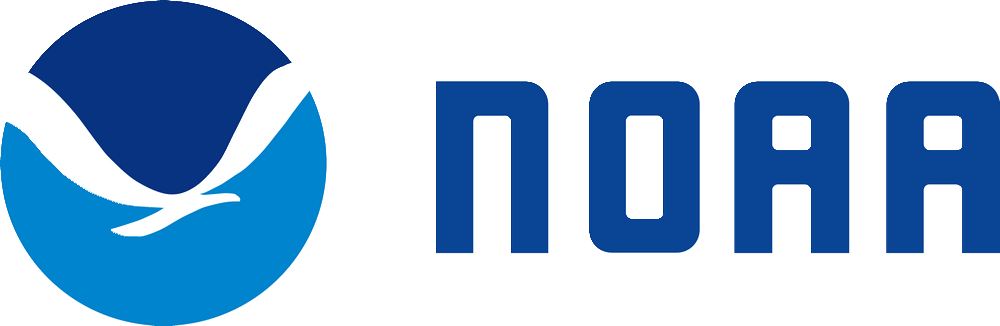

In [17]:
row

Once you are happy with the app or dashboard you have built you can annotate it with ``.servable()``. In the notebook, this annotation has no effect, but it will later indicate to the ``panel serve`` command that you want this particular component to be served. If you then go to the command line and run ``panel serve 02_Building_Panels.ipynb``, the code cells in the notebook will be executed and the resulting dashboard will be  available as a web server.

Row
    [0] Column
        [0] Markdown(str)
        [1] PNG(str, height=130)
        [2] Markdown(str)
        [3] Column
            [0] Column
                [0] IntSlider(end=287489, name='row')
            [1] Row
                [0] HTML(Styler, name='interactive00111')
    [1] Column
        [0] Markdown(str)
        [1] DataFrame(DataFrame, width=500)
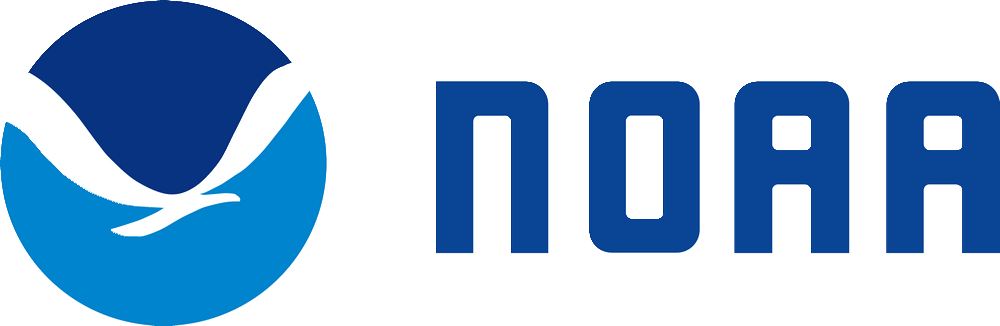

In [18]:
row.servable()

Note that despite this deep support for switching back and forth between Jupyter and deployed servers, Jupyter is in no way required for this process -- the same deployed dashboard can be obtained by simply exporting the code cells here into their own .py file, and doing `panel serve 02_Building_Panels.py`.

#### Exercise

Build a Panel component (or reuse one from a previous exercise) and call ``.show()`` on it.